In [1]:
#Imports and setup here
import numpy as np
import pandas as pd
import tensorflow as tf
import pathlib as pl
import os
from PIL import Image
from tqdm import tqdm
import random
import matplotlib.pyplot as plt
from sklearn import preprocessing 

In [2]:
len(tf.config.list_physical_devices('GPU'))

1

In [3]:
#Upload 1-1 and train.csv into the path shown below
root_path = 'D:/Datasets/dataset-shell_charger/Shell_cloud_coverage_hackathon/'

In [43]:
train_dataset = pd.read_csv(root_path + 'train.csv')
train_dataset.drop('Moisture', axis=1,  inplace=True)
train_dataset.drop('Tower Wet Bulb Temp [deg C]', axis=1, inplace=True)

#-------Replace Outliers with mean values----------|
train_dataset['Total Cloud Cover [%]'].replace(-7999, 48.62, inplace=True)
train_dataset['Snow Depth [cm]'] = list(map(lambda x: 1.9 if x < 0 else x, train_dataset['Snow Depth [cm]']))
train_dataset['Direct sNIP [W/m^2]'] = list(map(lambda x: 516 if x < 0 else x, train_dataset['Direct sNIP [W/m^2]']))
train_dataset['Global CMP22 (vent/cor) [W/m^2]'] = list(map(lambda x: 411 if x < 0 else x, train_dataset['Global CMP22 (vent/cor) [W/m^2]']))

train_dataset = train_dataset[train_dataset['Total Cloud Cover [%]'] > -1]
train_dataset = train_dataset[train_dataset['Global CMP22 (vent/cor) [W/m^2]'] >= 0]

print(train_dataset.head())

for column in train_dataset.columns:
    if column != "MST" and column!= "DATE (MM/DD)" and column != 'Total Cloud Cover [%]' and column != 'Precipitation (Accumulated) [mm]':
        print(column)
        max_value = train_dataset[column].max()
        min_value = train_dataset[column].min()
        train_dataset[column] = (train_dataset[column] - min_value)/(max_value - min_value)

train_dataset['Total Cloud Cover [%]'] = train_dataset['Total Cloud Cover [%]']/100
train_dataset.describe()

    DATE (MM/DD)    MST  Global CMP22 (vent/cor) [W/m^2]  Direct sNIP [W/m^2]  \
467          1/1  07:47                          14.4935             0.079127   
468          1/1  07:48                          16.5178           516.000000   
469          1/1  07:49                          18.6171           516.000000   
470          1/1  07:50                          20.5986           516.000000   
471          1/1  07:51                          22.4362           516.000000   

     Azimuth Angle [degrees]  Tower Dry Bulb Temp [deg C]  \
467                123.84491                        6.933   
468                124.01096                        6.793   
469                124.17734                        6.674   
470                124.34405                        6.646   
471                124.51110                        6.676   

     Tower Dew Point Temp [deg C]  Tower RH [%]  Total Cloud Cover [%]  \
467                        -5.597         38.24                    6.0  

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Albedo (CMP11)
count,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000
mean,0.288307,0.482967,0.500635,0.594900,0.515785,0.325795,0.486227,0.130709,0.374317,0.360512,0.363595,0.071896,0.133109
std,0.207459,0.356142,0.270197,0.207791,0.179887,0.236659,0.355915,0.087955,0.283672,0.103328,1.762774,0.129662,0.089602
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.108354,0.045450,0.264391,0.432695,0.379136,0.151006,0.140000,0.072495,0.119500,0.297639,0.000000,0.018388,0.090050
50%,0.249451,0.525892,0.501550,0.616560,0.507340,0.256127,0.410000,0.115139,0.312778,0.368649,0.000000,0.037041,0.102150
75%,0.436863,0.828980,0.736628,0.768234,0.652690,0.427052,0.880000,0.168443,0.698333,0.431141,0.000000,0.071888,0.122150
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,28.190000,1.000000,1.000000


In [5]:
train_dataset = train_dataset.dropna()
train_dataset.describe()

,Global CMP22 (vent/cor) [W/m^2],Direct sNIP [W/m^2],Azimuth Angle [degrees],Tower Dry Bulb Temp [deg C],Tower Dew Point Temp [deg C],Tower RH [%],Total Cloud Cover [%],Peak Wind Speed @ 6ft [m/s],Avg Wind Direction @ 6ft [deg from N],Station Pressure [mBar],Precipitation (Accumulated) [mm],Snow Depth [cm],Albedo (CMP11)
count,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000,252258.000000
mean,0.288307,0.482967,0.500635,0.594900,0.515785,0.325795,0.486227,0.130709,0.374317,0.360512,0.012898,0.071896,0.133109
std,0.207459,0.356142,0.270197,0.207791,0.179887,0.236659,0.355915,0.087955,0.283672,0.103328,0.062532,0.129662,0.089602
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.108354,0.045450,0.264391,0.432695,0.379136,0.151006,0.140000,0.072495,0.119500,0.297639,0.000000,0.018388,0.090050
50%,0.249451,0.525892,0.501550,0.616560,0.507340,0.256127,0.410000,0.115139,0.312778,0.368649,0.000000,0.037041,0.102150
75%,0.436863,0.828980,0.736628,0.768234,0.652690,0.427052,0.880000,0.168443,0.698333,0.431141,0.000000,0.071888,0.122150
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


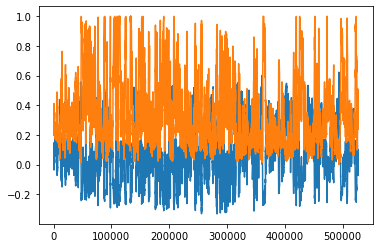

In [6]:
#plt.plot(train_dataset['Tower Dry Bulb Temp [deg C]'])
#plt.plot(train_dataset['Tower Dew Point Temp [deg C]'])
plt.plot(train_dataset['Tower Dry Bulb Temp [deg C]'] - train_dataset['Tower Dew Point Temp [deg C]'])
plt.plot(train_dataset['Tower RH [%]'])
plt.show() 

In [60]:
class FullDataset():
  def __init__(self, dataframe):
    self.dataframe = dataframe
    self.final_dataset = self.create_empty()
    self.dates = dataframe['DATE (MM/DD)'].unique()
    print(self.dates)
    random.shuffle(self.dates)
    self.dates = self.dates[:25]
    print(self.dates)

  def create_empty(self):
    def fake_generator():
      for _ in range(8):
        features = ()
        img_sample = np.zeros(shape=[256,256,3,])
        w_dat_sample = np.zeros(shape=[13,])
        for _ in range(20):
          features = features + (w_dat_sample,)

        for _ in range(20):
          features = features + (img_sample,)

        labels = 0
        yield features, labels

    out_types = ()
    for i in range(40):
      out_types = out_types + (tf.float64,)

    return tf.data.Dataset.from_generator(fake_generator, output_types=(out_types, tf.float64)) 

  def get_date(self,dataframe,date):
    df = dataframe
    df = df[df['DATE (MM/DD)']==date]
    df = df[df['Total Cloud Cover [%]'] > -1]
    df['MST'] = df['MST'] + ':00'
    df['MST'] = pd.to_timedelta(df['MST'])
    #df['DATE (MM/DD)'] = list(map(lambda x : int(x.split('/')[0]), df['DATE (MM/DD)']))
    df.drop('DATE (MM/DD)', axis=1, inplace=True)
    df = df.set_index('MST')
    label_df = df['Total Cloud Cover [%]']
    #df = df.drop('Total Cloud Cover [%]' , 1)

    offset_n = 10 - int(str(df.index[0])[-4])
    df_resampled = df.resample('10T', offset=f'{offset_n}T').mean()
    weather_df = df_resampled.iloc[:-12]

    indices = df_resampled.index.shift(12)
    max_in = label_df.index[-1]
    indices = indices[indices < max_in]
    indices = indices[indices.isin(label_df.index)]
    ix = indices.shift(-12,'10T')

    weather_df = weather_df[weather_df.index.isin(ix)]
    label_df = label_df[indices]


    return weather_df, label_df

  def get_images(self,weather_df,date):

    dat_dir = pl.Path(root_path + 'Image Data/')
    mon , day = date.split('/')
    if len(mon) < 2:
      mon = '0' + mon
    if len(day) < 2:
      day = '0' + day

    num_date = mon + day
    #------------------------Remove Duplicate--------------------------------------|
    def remove_duplicates(dir):
      unique = []
      for filename in os.listdir(dir):
          if os.path.isfile(filename):
              filehash = md5.md5(file(filename).read()).hexdigest()
              if filehash not in unique: 
                  unique.append(filehash)
              else: 
                  os.remove(filename)
#-----------------------------------------------------------------------------------|
    remove_duplicates(root_path + f'Image Data/{num_date}')
    #if length of image name is less than 10, add date to it
    filepaths = pd.Series(list(dat_dir.glob(f'{num_date}/*.jpg')), name='FilePaths').astype(str)

    def return_label(x):
      label0 = os.path.split(x)[1].split('.')[0]
      if len(label0) == 10:
        label0 = label0[4:]
      label0 = label0[:2] + ':' + label0[2:4] + ':' + label0[4:6]
      return label0

    filelabels = pd.Series(list(map(return_label, filepaths)), name='MST')

    filelabels = pd.to_timedelta(filelabels)
    filepaths.index = filelabels
    feature_ix = weather_df.index[weather_df.index.isin(filepaths.index)]
    filepaths = filepaths[feature_ix]
    weather_df = weather_df[weather_df.index.isin(feature_ix)]

    image_df = pd.DataFrame(filepaths)

    return image_df

  def generator(self, weather_df, image_df, label_df):
    for i in range(len(image_df)-20):
      imgs = ()
      w_dats = ()
      for j in range(20):
        pth = image_df['FilePaths'][i+j]
        img = Image.open(pth)
        img = np.array(img.resize((256,256)))/255
        obj = Defisheye(img, dtype='linear', format='circular', fov=180, pfov=165)
        img = obj.convert()
        img = tf.convert_to_tensor(img)
        w_dat = tf.convert_to_tensor(weather_df.iloc[i+j])

        imgs = imgs + (img,)
        w_dats = w_dats + (w_dat,)
      lbl = tf.convert_to_tensor(label_df.iloc[i+20])

      yield w_dats + imgs, lbl  

  def get_dataset(self):
    for d in tqdm(self.dates):
      day_weather_df, day_labels = self.get_date(self.dataframe, d)
      day_images_df = self.get_images(day_weather_df, d)

      def gen():
        return self.generator(day_weather_df, day_images_df, day_labels)

      out_types = ()
      for i in range(40):
        out_types = out_types + (tf.float64,)

      day_dataset =  tf.data.Dataset.from_generator(gen, output_types=(out_types, tf.float64))

      self.final_dataset = self.final_dataset.concatenate(day_dataset)
    
    self.final_dataset = self.final_dataset.batch(8).shuffle(buffer_size=800)
    
    return self.final_dataset

In [61]:
dat_class = FullDataset(train_dataset)
final_dat = dat_class.get_dataset()

['1/1' '1/2' '1/3' '1/4' '1/5' '1/6' '1/7' '1/8' '1/9' '1/10' '1/11'
 '1/12' '1/13' '1/14' '1/15' '1/16' '1/17' '1/18' '1/19' '1/20' '1/21'
 '1/22' '1/23' '1/24' '1/25' '1/26' '1/27' '1/28' '1/29' '1/30' '1/31'
 '2/1' '2/2' '2/3' '2/4' '2/5' '2/6' '2/7' '2/8' '2/9' '2/10' '2/11'
 '2/12' '2/13' '2/14' '2/15' '2/16' '2/17' '2/18' '2/19' '2/20' '2/21'
 '2/22' '2/23' '2/24' '2/25' '2/26' '2/27' '2/28' '2/29' '3/1' '3/2' '3/3'
 '3/4' '3/5' '3/6' '3/7' '3/8' '3/9' '3/10' '3/11' '3/12' '3/13' '3/14'
 '3/15' '3/16' '3/17' '3/18' '3/19' '3/20' '3/21' '3/22' '3/23' '3/24'
 '3/25' '3/26' '3/27' '3/28' '3/29' '3/30' '3/31' '4/1' '4/2' '4/3' '4/4'
 '4/5' '4/6' '4/7' '4/8' '4/9' '4/10' '4/11' '4/12' '4/13' '4/14' '4/15'
 '4/16' '4/17' '4/18' '4/19' '4/20' '4/21' '4/22' '4/23' '4/24' '4/25'
 '4/26' '4/27' '4/28' '4/29' '4/30' '5/1' '5/2' '5/3' '5/4' '5/5' '5/6'
 '5/7' '5/8' '5/9' '5/10' '5/11' '5/12' '5/13' '5/14' '5/15' '5/16' '5/17'
 '5/18' '5/19' '5/20' '5/21' '5/22' '5/23' '5/24' '5/25' '5/26' '5

100%|██████████| 25/25 [00:29<00:00,  1.19s/it]


In [11]:
for i in final_dat:
  print(i[0][0])

tf.Tensor(
[[0.32361292 0.88904087 0.28844409 0.19220159 0.20052164 0.4105329
  0.053      0.01215352 0.01561111 0.6101799  0.07388436 0.40056754
  0.41246   ]
 [0.34468569 0.90621203 0.29767916 0.19175663 0.20068309 0.41152362
  0.063      0.         0.         0.61176326 0.08109259 0.40438895
  0.410235  ]
 [0.36387898 0.9174653  0.30719313 0.20014703 0.20164191 0.39647513
  0.063      0.         0.         0.61164004 0.08109259 0.40283768
  0.40866   ]
 [0.38290896 0.92635195 0.31699697 0.21207003 0.21275771 0.39154239
  0.076      0.01705757 0.14933333 0.61045714 0.08109259 0.39368142
  0.4071    ]
 [0.39966145 0.93466545 0.3271001  0.22446121 0.22053008 0.38069663
  0.074      0.02857143 0.16836667 0.6100382  0.08109259 0.39197881
  0.40628   ]
 [0.416219   0.94297512 0.33750988 0.21053395 0.22543097 0.41556992
  0.057      0.01812367 0.18991667 0.61102395 0.08109259 0.40438895
  0.40621   ]
 [0.43054282 0.9505911  0.34823119 0.22815438 0.23422922 0.39533841
  0.054      0.0159914

## Primitive Data

In [23]:
def preprocess(dataframe):
  #removes bad data from the dataset
  df = dataframe
  df = df[df['DATE (MM/DD)']=='1/1']
  df.replace(-7999, 48.622671, inplace=True)
  df = df[df['Total Cloud Cover [%]'] > -1]
  #---------feature engineering------------|
  
  return df

#preprocesses the data and changes the index to time
data1_1 = preprocess(train_dataset)
data1_1['MST'] = data1_1['MST'] + ":00"
data1_1['MST'] = pd.to_timedelta(data1_1['MST'])

data1_1['DATE (MM/DD)'] = list(map(lambda x : int(x.split('/')[0]), data1_1['DATE (MM/DD)']))
data1_1 = data1_1.set_index('MST')
label_df = data1_1['Total Cloud Cover [%]']
data1_1 = data1_1.drop('Total Cloud Cover [%]' , 1)

#resamples the weather data to be same as image frequency
print(data1_1.index[0])
offset_n = 10 - int(str(data1_1.index[0])[-4])
df_resampled = data1_1.resample('10T', offset=f'{offset_n}T').mean()
weather_df = df_resampled.iloc[:-12]

#gives labels at the resampled indices
indices = df_resampled.index.shift(12)
max_in = label_df.index[-1]
indices = indices[indices < max_in]
ix = indices.shift(-12)
weather_df = weather_df[weather_df.index.isin(ix)]
label_df = label_df[indices]
#label_df = label_df/100

#final dat is weather_df, final label is label_df

C:\Users\amanc\anaconda3\lib\site-packages\pandas\core\frame.py:4379: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


0 days 07:47:00


In [60]:
indices.shift(-12)

TimedeltaIndex(['0 days 07:50:00', '0 days 08:00:00', '0 days 08:10:00',
                '0 days 08:20:00', '0 days 08:30:00', '0 days 08:40:00',
                '0 days 08:50:00', '0 days 09:00:00', '0 days 09:10:00',
                '0 days 09:20:00', '0 days 09:30:00', '0 days 09:40:00',
                '0 days 09:50:00', '0 days 10:00:00', '0 days 10:10:00',
                '0 days 10:20:00', '0 days 10:30:00', '0 days 10:40:00',
                '0 days 10:50:00', '0 days 11:00:00', '0 days 11:10:00',
                '0 days 11:20:00', '0 days 11:30:00', '0 days 11:40:00',
                '0 days 11:50:00', '0 days 12:00:00', '0 days 12:10:00',
                '0 days 12:20:00', '0 days 12:30:00', '0 days 12:40:00',
                '0 days 12:50:00', '0 days 13:00:00', '0 days 13:10:00',
                '0 days 13:20:00', '0 days 13:30:00', '0 days 13:40:00',
                '0 days 13:50:00', '0 days 14:00:00', '0 days 14:10:00',
                '0 days 14:20:00'],
               

In [31]:
tf.convert_to_tensor(weather_df.iloc[0])

<tf.Tensor: shape=(15,), dtype=float64, numpy=
array([ 1.00000000e+00,  2.18665000e+01,  1.25615500e-01,  1.24596125e+02,
        7.14180000e+00,  1.58760000e+00, -5.33140000e+00,  3.85760000e+01,
        3.20000000e+00,  2.56790000e+02,  8.01934200e+02,  0.00000000e+00,
        2.44800000e-01,  0.00000000e+00,  1.85940000e-01])>

In [32]:
#Creates a dataframe of the images and their times

dat_dir = pl.Path(root_path + 'Image Data/')
filepaths = pd.Series(list(dat_dir.glob(r'0101/*.jpg')), name='FilePaths').astype(str)

def return_label(x):
  label0 = os.path.split(x)[1].split('.')[0]
  label0 = label0[4:]
  label0 = label0[:2] + ':' + label0[2:4] + ':' + label0[4:]
  return label0

filelabels = pd.Series(list(map(return_label, filepaths)), name='MST')
filelabels = pd.to_timedelta(filelabels)

filepaths.index = filelabels
feature_ix = weather_df.index
filepaths = filepaths[feature_ix]

image_df = pd.DataFrame(filepaths)
#image_df is the final dataset with paths to all the images

image_df and weather_df are the two feature sets. we pass both of these into as the x axis. the labels_df column is the prediction column, it's indices don't match but the iloc does, so be careful to use iloc while turning into tf dataset. We will use a flow into generator for the images, while we will just turn into tensorflow dataset for weather data, so there is no need to concatenate the two.

In [ ]:
label_df.iloc[9]

97

# Defisheye Class

In [8]:
"""
Defisheye algorithm.
Developed by: E. S. Pereira.
e-mail: pereira.somoza@gmail.com
Based in the work of F. Weinhaus.
http://www.fmwconcepts.com/imagemagick/defisheye/index.php
Copyright [2019] [E. S. Pereira]
   Licensed under the Apache License, Version 2.0 (the "License");
   you may not use this file except in compliance with the License.
   You may obtain a copy of the License at
       http://www.apache.org/licenses/LICENSE-2.0
   Unless required by applicable law or agreed to in writing, software
   distributed under the License is distributed on an "AS IS" BASIS,
   WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
   See the License for the specific language governing permissions and
   limitations under the License.
"""
import cv2
from numpy import arange, sqrt, arctan, sin, tan, zeros, array, meshgrid, pi
from numpy import argwhere, hypot


class Defisheye:
    """
    Defisheye
    fov: fisheye field of view (aperture) in degrees
    pfov: perspective field of view (aperture) in degrees
    xcenter: x center of fisheye area
    ycenter: y center of fisheye area
    radius: radius of fisheye area
    angle: image rotation in degrees clockwise
    dtype: linear, equalarea, orthographic, stereographic
    format: circular, fullframe
    """

    def __init__(self, infile, **kwargs):
        vkwargs = {"fov": 180,
                   "pfov": 120,
                   "xcenter": None,
                   "ycenter": None,
                   "radius": None,
                   "angle": 0,
                   "dtype": "equalarea",
                   "format": "fullframe"
                   }
        self._start_att(vkwargs, kwargs)

        if type(infile) == str:
            _image = cv2.imread(infile)
        elif type(infile) == np.ndarray:
            _image = infile
        else:
            raise ImageError("Image format not recognized")


        width = _image.shape[1]
        height = _image.shape[0]
        xcenter = width // 2
        ycenter = height  // 2

        dim = min(width, height)
        x0 = xcenter - dim // 2
        xf = xcenter + dim // 2
        y0 = ycenter - dim // 2
        yf = ycenter + dim // 2

        self._image = _image[y0:yf, x0:xf, :]

        self._width = self._image.shape[1]
        self._height = self._image.shape[0]

        if self._xcenter is None:
            self._xcenter = (self._width - 1) // 2

        if self._ycenter is None:
            self._ycenter = (self._height - 1) // 2

    def _map(self, i, j, ofocinv, dim):

        xd = i - self._xcenter
        yd = j - self._ycenter

        rd = hypot(xd, yd)
        phiang = arctan(ofocinv * rd)

        if self._dtype == "linear":
            ifoc = dim * 180 / (self._fov * pi)
            rr = ifoc * phiang
            # rr = "rr={}*phiang;".format(ifoc)

        elif self._dtype == "equalarea":
            ifoc = dim / (2.0 * sin(self._fov * pi / 720))
            rr = ifoc * sin(phiang / 2)
            # rr = "rr={}*sin(phiang/2);".format(ifoc)

        elif self._dtype == "orthographic":
            ifoc = dim / (2.0 * sin(self._fov * pi / 360))
            rr = ifoc * sin(phiang)
            # rr="rr={}*sin(phiang);".format(ifoc)

        elif self._dtype == "stereographic":
            ifoc = dim / (2.0 * tan(self._fov * pi / 720))
            rr = ifoc * tan(phiang / 2)

        rdmask = rd != 0
        xs = xd.copy()
        ys = yd.copy()

        xs[rdmask] = (rr[rdmask] / rd[rdmask]) * xd[rdmask] + self._xcenter
        ys[rdmask] = (rr[rdmask] / rd[rdmask]) * yd[rdmask] + self._ycenter

        xs[~rdmask] = 0
        ys[~rdmask] = 0

        xs = xs.astype(int)
        ys = ys.astype(int)
        return xs, ys

    def convert(self):
        if self._format == "circular":
            dim = min(self._width, self._height)
        elif self._format == "fullframe":
            dim = sqrt(self._width ** 2.0 + self._height ** 2.0)

        if self._radius is not None:
            dim = 2 * self._radius

        # compute output (perspective) focal length and its inverse from ofov
        # phi=fov/2; r=N/2
        # r/f=tan(phi);
        # f=r/tan(phi);
        # f= (N/2)/tan((fov/2)*(pi/180)) = N/(2*tan(fov*pi/360))

        ofoc = dim / (2 * tan(self._pfov * pi / 360))
        ofocinv = 1.0 / ofoc

        i = arange(self._width)
        j = arange(self._height)
        i, j = meshgrid(i, j)

        xs, ys, = self._map(i, j, ofocinv, dim)
        img = self._image.copy()

        img[i, j, :] = self._image[xs, ys, :]
        #cv2.imwrite(outfile, img)
        return img

    def _start_att(self, vkwargs, kwargs):
        """
        Starting atributes
        """
        pin = []

        for key, value in kwargs.items():
            if key not in vkwargs:
                raise NameError("Invalid key {}".format(key))
            else:
                pin.append(key)
                setattr(self, "_{}".format(key), value)

        pin = set(pin)
        rkeys = set(vkwargs.keys()) - pin
        for key in rkeys:
            setattr(self, "_{}".format(key), vkwargs[key])

    """© 2021 GitHub, Inc.
    Terms
    Privacy
    Security
    Status
    Docs"""


# Dataset Creator

In [ ]:
def combined_generator():
  for i in range(len(image_df)-20):
    imgs = ()
    w_dats = ()
    for j in range(20):
      pth = image_df['FilePaths'][i+j]
      img = Image.open(pth)
      img = np.array(img.resize((256,256)))/255
      obj = Defisheye(img, dtype='linear', format='circular', fov=180, pfov=165)
      img = obj.convert()
      img = tf.convert_to_tensor(img)
      w_dat = tf.convert_to_tensor(weather_df.iloc[i+j])

      imgs = imgs + (img,)
      w_dats = w_dats + (w_dat,)

    lbl = tf.convert_to_tensor(label_df.iloc[i+4])

    yield w_dats + imgs, lbl  

out_types = ()
for i in range(40):
  out_types = out_types + (tf.float64,)

final_dataset = tf.data.Dataset.from_generator(combined_generator, output_types=(out_types, tf.float64))
final_dataset = final_dataset.batch(4).shuffle(buffer_size=40)

In [ ]:
for i in final_dataset:
  print(i[1])

tf.Tensor([90. 82. 48. 43.], shape=(4,), dtype=float64)
tf.Tensor([96. 91. 89. 90.], shape=(4,), dtype=float64)
tf.Tensor([91. 90. 91. 89.], shape=(4,), dtype=float64)
tf.Tensor([96. 97. 97. 97.], shape=(4,), dtype=float64)
tf.Tensor([95. 96. 97. 96.], shape=(4,), dtype=float64)


# Model

In [51]:
class HotModel():
  def __init__(self, n_inputs):
    self.n_inputs = n_inputs
    self.WeatherInputs = ()
    self.ImageInputs = ()
    self.WeatherOutputs = ()
    self.ImageOutputs = ()
    self.Outs = ()
    self.create_inputs()
    self.w_dense1 = tf.keras.layers.Dense(64, activation='relu', name='weather_dense1')
    self.w_dense2 = tf.keras.layers.Dense(128, activation='relu', name='weather_dense2')
    self.w_dense3 = tf.keras.layers.Dense(128, activation='relu', name='weather_dense3')
    self.w_dense4 = tf.keras.layers.Dense(64, activation='relu', name='Weather_Output')

    self.im_conv1 = tf.keras.layers.Conv2D(16, kernel_size=5, name='image_conv1')
    self.im_conv2 = tf.keras.layers.Conv2D(32, kernel_size=3, name='image_conv2')
    self.im_conv3 = tf.keras.layers.Conv2D(64, kernel_size=3, name='image_conv3')
    self.im_conv4 = tf.keras.layers.Conv2D(64, kernel_size=3, name='image_conv4')

  def create_inputs(self):
    for i in range(self.n_inputs):
      w_name = 'Weather_Input{}'.format(i)
      exec('self.WInput{} = tf.keras.layers.Input(shape=(13,), name=w_name)'.format(i))
      exec('self.WeatherInputs = self.WeatherInputs + (self.WInput{},)'.format(i))
      im_name = 'Image_Input{}'.format(i)
      exec('self.ImInput{} = tf.keras.layers.Input(shape=(256,256,3,), name=im_name)'.format(i))
      exec('self.ImageInputs = self.ImageInputs + (self.ImInput{},)'.format(i))

  def create_weather_output(self, WInput):
    outs = self.w_dense1(WInput)
    outs = self.w_dense2(outs)
    outs = self.w_dense3(outs)
    outs = self.w_dense4(outs)

    return outs

  def create_image_output(self, ImInput):
    outs = self.im_conv1(ImInput)
    outs = self.im_conv2(outs)
    outs = self.im_conv3(outs)
    outs = self.im_conv4(outs)
    outs = tf.keras.layers.GlobalAveragePooling2D()(outs)

    return outs

  def get_outputs(self):
    for i in range(self.n_inputs):
      exec(f'self.WOutput{i} = self.create_weather_output(self.WInput{i})')
      exec(f'self.WeatherOutputs = self.WeatherOutputs + (self.WOutput{i},)')
      exec(f'self.ImOutput{i} = self.create_image_output(self.ImInput{i})')
      exec(f'self.ImageOutputs = self.ImageOutputs + (self.ImOutput{i},)')

  def create_model(self):
    self.get_outputs()
    for i in range(self.n_inputs):
      c_name = 'concat_layer{}'.format(i)
      exec(f'self.outs{i} = tf.keras.layers.concatenate((self.ImOutput{i}, self.WOutput{i}), axis=1)')
      exec(f'self.Outs = self.Outs + (self.outs{i},)')

    outs = tf.stack(self.Outs, axis=1)
    outs = tf.keras.layers.LSTM(256, return_sequences=True, name='lstm1')(outs)
    outs = tf.keras.layers.LSTM(256, return_sequences=True, name='lstm2')(outs)
    outs = tf.keras.layers.LSTM(128, return_sequences=True, name='lstm3')(outs)
    outs = tf.keras.layers.LSTM(128, return_sequences=False, name='lstm4')(outs)
    outs = tf.keras.layers.Dense(128, activation='relu')(outs)
    outs = tf.keras.layers.Dense(128, activation='relu')(outs)
    outs = tf.keras.layers.Dense(64, activation='relu')(outs)
    outs = tf.keras.layers.Dense(64, activation='relu')(outs)
    outs = tf.keras.layers.Dense(32, activation='relu')(outs)
    outs = tf.keras.layers.Dense(1)(outs)

    model = tf.keras.Model(inputs=self.WeatherInputs + self.ImageInputs, outputs=outs)

    return model 

In [53]:
model = HotModel(20).create_model()
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Image_Input0 (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Image_Input1 (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Image_Input2 (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
Image_Input3 (InputLayer)       [(None, 256, 256, 3) 0                                            
____________________________________________________________________________________________

# Training

In [62]:
model.load_weights(root_path + 'model_weights_0')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')
history = model.fit(final_dat, epochs=20)
model.save_weights(root_path+'model_weights_1')

Epoch 1/20


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  Failed to allocate memory for the batch of component 30
	 [[node IteratorGetNext (defined at <ipython-input-62-5eff34127922>:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

	 [[IteratorGetNext/_62]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

  (1) Resource exhausted:  Failed to allocate memory for the batch of component 30
	 [[node IteratorGetNext (defined at <ipython-input-62-5eff34127922>:3) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1849293]

Function call stack:
train_function -> train_function


In [ ]:
def return_test(i):
  imgs = ()
  w_dats = ()
  for j in range(20):
    pth = image_df['FilePaths'][i+j]
    img = Image.open(pth)
    img = np.array(img.resize((256,256)))/255
    img = tf.convert_to_tensor(img)
    img = tf.expand_dims(img, axis=0)
    w_dat = tf.convert_to_tensor(weather_df.iloc[i+j])
    w_dat = tf.expand_dims(w_dat, axis=0)

    imgs = imgs + (img,)
    w_dats = w_dats + (w_dat,)

  return w_dats + imgs

test_in = return_test(9) 

In [ ]:
model.load_weights(root_path+'model_weights')
test_out = model(test_in)

tf.Tensor([[79.38609]], shape=(1, 1), dtype=float32)


TODO-
*   Feature Engineering
*   Re-Training and getting scores after Feature Engineering



In [55]:
test_folder = 'D:/Datasets/dataset-shell_charger/test/test/'

In [56]:
def get_all_scores():
    def return_test_dataset(test_filepaths, test_dat):
        imgs = ()
        w_dats = ()
        for j in range(20):
            pth = test_filepaths.iloc[-j]
            img = Image.open(pth)
            img = np.array(img.resize((256,256)))/255
            obj = Defisheye(img, dtype='linear', format='circular', fov=180, pfov=165)
            img = obj.convert()
            img = tf.convert_to_tensor(img)
            img = tf.expand_dims(img, axis=0)
            w_dat = tf.convert_to_tensor(test_dat.iloc[-j])
            w_dat = tf.expand_dims(w_dat, axis=0)

            imgs = imgs + (img,)
            w_dats = w_dats + (w_dat,)

        return w_dats + imgs

    ans_array = []
    for t in tqdm(range(1,300,1)):
        test_dat = pd.read_csv(test_folder + f'{t}/weather_data.csv')
        #--------PreProcessing-------------------|
        test_dat.drop('Moisture', axis=1, inplace=True)
        test_dat.drop('Tower Wet Bulb Temp [deg C]', axis=1, inplace=True)
        test_dat['Total Cloud Cover [%]'].replace(-7999, 48.62, inplace=True)
        test_dat['Snow Depth [cm]'] = list(map(lambda x: 1.9 if x < 0 else x, test_dat['Snow Depth [cm]']))
        test_dat['Direct sNIP [W/m^2]'] = list(map(lambda x: 516 if x < 0 else x, test_dat['Direct sNIP [W/m^2]']))
        test_dat['Global CMP22 (vent/cor) [W/m^2]'] = list(map(lambda x: 411 if x < 0 else x, test_dat['Global CMP22 (vent/cor) [W/m^2]']))

        test_dat = test_dat[test_dat['Total Cloud Cover [%]'] > -1]
        test_dat = test_dat[test_dat['Global CMP22 (vent/cor) [W/m^2]'] >= 0]

        for column in test_dat.columns:
            if column != "Precipitation (Accumulated) [mm]" and column!= "Time [Mins]" and column != 'Total Cloud Cover [%]':
                max_value = test_dat[column].max()
                std_value = test_dat[column].std()
                min_value = test_dat[column].min()
                test_dat[column] = (test_dat[column] - min_value)/std_value

        test_dat['Total Cloud Cover [%]'] = test_dat['Total Cloud Cover [%]']/100

        for i in range(len(test_dat['Time [Mins]'])):
            test_dat['Time [Mins]'].iloc[i] = str(int(int(test_dat['Time [Mins]'].iloc[i])/60)) + ':' +  str(int(test_dat['Time [Mins]'].iloc[i])%60) + ':00'

        test_dat['Time [Mins]'] = pd.to_timedelta(test_dat['Time [Mins]'])
        test_dat = test_dat.set_index('Time [Mins]')
        test_dat = test_dat.resample('10T').mean()
        #print(test_dat.isna().sum())

        t_directory = pl.Path(test_folder+f'{t}/')
        test_filepaths = pd.Series(list(t_directory.glob(r'*.jpg')), name='FilePaths')

        test_in = return_test_dataset(test_filepaths, test_dat)
        #print(test_in)
        ans_array.append(model(test_in))

    return ans_array

In [57]:
model.load_weights(root_path + 'model_weights_0')
ans_s = get_all_scores()

  0%|          | 0/299 [00:00<?, ?it/s]C:\Users\amanc\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  0%|          | 1/299 [00:05<28:34,  5.75s/it]C:\Users\amanc\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
  1%|          | 2/299 [00:06<21:34,  4.36s/it]C:\Users\amanc\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the

In [58]:
print(np.array(ans_s))

[[[0.259841  ]]

 [[0.25986943]]

 [[0.25984055]]

 [[0.25985557]]

 [[0.25987262]]

 [[0.25984228]]

 [[0.2598618 ]]

 [[0.25986803]]

 [[0.2598433 ]]

 [[0.25984788]]

 [[0.25984675]]

 [[0.25984973]]

 [[0.25986224]]

 [[0.25987256]]

 [[0.25986248]]

 [[0.25986546]]

 [[0.25985014]]

 [[0.2598494 ]]

 [[0.2598578 ]]

 [[0.2598408 ]]

 [[0.25984892]]

 [[0.25985867]]

 [[0.25985646]]

 [[0.25986296]]

 [[0.25985515]]

 [[0.2598448 ]]

 [[0.25984472]]

 [[0.25987524]]

 [[0.25986424]]

 [[0.25984627]]

 [[0.25986475]]

 [[0.2598555 ]]

 [[0.25986063]]

 [[0.25983137]]

 [[0.2598641 ]]

 [[0.25987166]]

 [[0.25985223]]

 [[0.25985876]]

 [[0.2598394 ]]

 [[0.2598582 ]]

 [[0.25984442]]

 [[0.2598516 ]]

 [[0.25984916]]

 [[0.25985527]]

 [[0.25984973]]

 [[0.2598626 ]]

 [[0.25984296]]

 [[0.2598546 ]]

 [[0.25985748]]

 [[0.25986248]]

 [[0.25987074]]

 [[0.25985408]]

 [[0.25986546]]

 [[0.25984457]]

 [[0.25985384]]

 [[0.2598568 ]]

 [[0.25985542]]

 [[0.25984368]]

 [[0.25987282]